In [1]:
import numpy as np
import pandas as pd

In [42]:
# Load the pickled predictors
import pickle
predictors = pickle.load(open("predictors.pkl", "rb"))

sentiment_by_date = pickle.load(open("sentiment_by_date.pkl", "rb"))

#  Do we need to mess with this?
#  Recurrent Neural Networks for Multivariate Time Series with Missing Values
#  https://www.nature.com/articles/s41598-018-24271-9
# predictors.head()
sentiment_by_date.head(3)

sentiment,Negative,Neutral,Positive
Date,,,
2017-09-22,1,4,5
2017-09-24,0,1,0
2017-09-25,3,2,5


In [43]:
daily_stock = pickle.load(open("daily_stock.pkl", "rb"))
daily_stock[["AAPL"]].head(3)

Name,AAPL
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428


In [45]:
aapl = sentiment_by_date.merge(daily_stock[["AAPL"]],
             how="outer", 
    right_index = True, 
    left_index = True
)

In [71]:
examine = predictors[["gold", "crude_oil", "futures_10"]].fillna(0.0)
examine = examine.merge(aapl,
             how="outer", 
    right_index = True, 
    left_index = True
)
examine = examine[~examine.AAPL.isnull()].fillna(0.0)

In [72]:
float_data = np.array(examine)
print(len(float_data))

1259


In [73]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [74]:
# [ : val_slice : test_slice ]
val_slice = 800
test_slice = 1100


mean = float_data[:val_slice].mean(axis=0)
float_data -= mean
std = float_data[:val_slice].std(axis=0)
float_data /= std

float_data

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([[ 2.18904235,  0.76939297,  1.60981269, ...,         nan,
                nan, -1.18941722],
       [ 2.15743809,  0.81875292,  1.59734976, ...,         nan,
                nan, -1.1580931 ],
       [ 2.04745529,  0.836839  ,  1.49141489, ...,         nan,
                nan, -1.23421531],
       ..., 
       [ 0.50693759, -0.42014404, -2.31600883, ...,         nan,
                inf,  2.73654177],
       [ 0.54511553, -0.44878034, -2.22253689, ...,         inf,
                inf,  3.02621899],
       [ 0.46345014, -0.5090673 , -2.43440663, ...,         nan,
                inf,  2.87163589]])

In [75]:
lookback = 5 # How many timesteps back the input data should go.
step = 1 # The period, in timesteps, at which you sample data. 
delay = 1 # How many timesteps in the future the target should be.
batch_size = 32 # Number big enough that it could be representatative of the whole 

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=val_slice,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=(val_slice+1),
                        max_index=test_slice,
                        step=step,
                        batch_size=batch_size)

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=test_slice+1,
                        max_index=None,
                        step=step,
                        batch_size=batch_size)

val_steps = (test_slice - (val_slice+1) - lookback)
test_steps = (len(float_data) - (test_slice+1) - lookback)

In [76]:
print(val_steps, test_steps)
float_data.shape[-1] # number of variables

294 153


7

In [77]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [78]:
model = Sequential()
# Can replace GRU with RNN or LTSM for experimentation.
model.add(layers.GRU(16, input_shape=(None, float_data.shape[-1]),
                    recurrent_dropout = .5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


In [79]:
history = model.fit_generator(train_gen,
                            steps_per_epoch=16, # 
                            epochs=16, # passes through the training data
                            validation_data=val_gen,
                            validation_steps=val_steps,
                             verbose=1)

Epoch 1/16
16/16 [==============================] - 3s 169ms/step - loss: nan - val_loss: nan
Epoch 2/16
16/16 [==============================] - 1s 78ms/step - loss: nan - val_loss: nan
Epoch 3/16
16/16 [==============================] - 1s 72ms/step - loss: nan - val_loss: nan
Epoch 4/16
16/16 [==============================] - 1s 66ms/step - loss: nan - val_loss: nan
Epoch 5/16
16/16 [==============================] - 1s 62ms/step - loss: nan - val_loss: nan
Epoch 6/16
16/16 [==============================] - 1s 64ms/step - loss: nan - val_loss: nan
Epoch 7/16
16/16 [==============================] - 1s 59ms/step - loss: nan - val_loss: nan
Epoch 8/16
16/16 [==============================] - 1s 62ms/step - loss: nan - val_loss: nan
Epoch 9/16
16/16 [==============================] - 1s 63ms/step - loss: nan - val_loss: nan
Epoch 10/16
16/16 [==============================] - 1s 68ms/step - loss: nan - val_loss: nan
Epoch 11/16
16/16 [==============================] - 1s 58ms/step - 

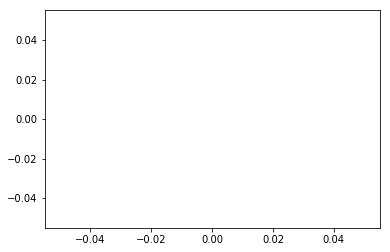

In [61]:
% matplotlib inline
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs, val_loss, 'b', label='Validation loss')